# How active is myDRE being used?
    
Activity is measured via this script by:
- Succeeded VM starts

## How to
### in portal.azure.com
- Log into portal.azure.com
- Select a Workspace Subscription
- Select Activity log
- Edit Columns, minimum needed
    - Operation name
    - Time
    - Event initiated by
    - Resource group
    - Resource
- Adjust the Subscription scope (it is possible to select multiple subscriptions)
- Adjust the Timespan (max a month, combine multiple months by saving if need be)
- Filter Operation: Start Virtual Machine (Microsoft.Compute/virtualMachine/start action)
- Download as CSV

### in Jupyter notebook / Python
- Copy the CSV in the same dir as Jupyter notebook / Python
- Update Sub_Dict.csv if needed
     - The Sub_Dict.csv does contain only part of the Subscription ID to provide protection against misuse
- Change the SOURCE_FILE in cell 2
- Run the script
- Some output CSVs are generated for closer inspection/use in Excel

In [1]:
import polars as pl
import pyarrow
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# QueryREsult (2).csv = All VM starts that Succeeded
# TENANT = 'RUMC'
SOURCE_FILE = 'QueryResult-2023-01.csv'
file_exportUser = 'exportUsers_2023-2-10.csv'

raw = pl.read_csv('Data/'+SOURCE_FILE)
succeededVMstarted= raw.filter(pl.col('Status') == 'Succeeded')

exportUser = pl.read_csv('Source/'+file_exportUser)
user_alternate_dic = {x:y for x,y in zip(exportUser['userPrincipalName'],exportUser['alternateEmailAddress'])}

In [3]:
#print(succeededVMstarted.columns)

In [4]:
# Get subscription dictionary to replace UUIDs with readable IDs
CLIENT_FILE='CLIENT.csv'
df=pd.read_csv('Source/'+CLIENT_FILE).set_index('id')
client_dictionary=df.to_dict()
SOURCE_FILE='Sub_Dict.csv'
df=pd.read_csv('Source/'+SOURCE_FILE).set_index('id')
subscription_dictionary = df.to_dict()

In [5]:
# limit to only columns needed
reduced_data=succeededVMstarted.select(['Time', 'Resource group', 'Resource', 'Event initiated by', 'Subscription'])

# replace Subscription ID with meaningful
reduced_data=reduced_data.with_columns(reduced_data['Subscription'].apply(lambda x: subscription_dictionary['name'][x[:15]][18:]))

# Create dataset with at most one successful login per day
reduced_data=reduced_data.with_columns(reduced_data['Time'].apply(lambda x: x[:-14]))
reduced_data=reduced_data.with_columns((pl.col('Resource group') + '_server' + pl.col('Resource').apply(lambda x: x[-2:].replace('r', '0'))).alias('VM'))
reduced_data=reduced_data.with_columns((pl.col('Subscription').apply(lambda x: x.split('-')[0])).alias('Tenant'))
# reduced_data = reduced_data[['Time', 'Resource group', 'VM', 'Event initiated by']].unique()

# limit to only columns of interest
reduced_data=reduced_data.with_columns(pl.lit(1).alias('Counter'))
reduced_data=reduced_data.select(['Time', 'Resource group', 'Event initiated by', 'VM', 'Subscription','Counter','Tenant'])
# print(reduced_data)
date=f'{min(reduced_data["Time"])} - {max(reduced_data["Time"])}'
# reduced_data.write_csv('myDRE/reduced_data '+ date + '.csv')

## VMs Start Succeeded in Subscription

- Number of VM succeeded starts per day per subsription"

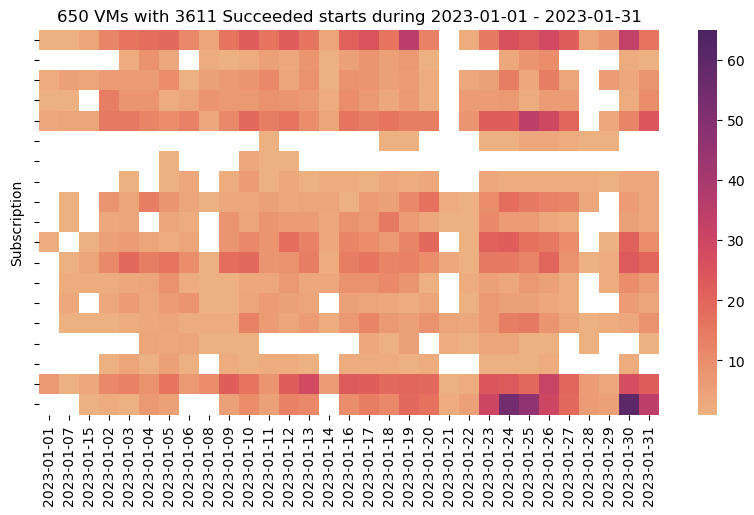

In [6]:
item = 'Subscription'
table=reduced_data.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
vms = len(set(reduced_data['VM']))
vm_starts = sum(reduced_data['Counter'])
title=f'{vms} VMs with {vm_starts} Succeeded starts during {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
figure = sns.heatmap(result, cmap='flare', mask=result<1, vmin=1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
ax.set_yticklabels([])
figure.invert_xaxis()
figure.figure.savefig('myDRE/sub_vm_activity_' +date+'.png',  bbox_inches='tight')

In [7]:
item1 = 'Subscription'
item2 = 'Resource group'
sorton = 'VMs started'
sorton = ['Subscription', 'VMs started']
# sorton = 'Subscription'
table2=(reduced_data
       .groupby([item1, item2])
       .agg([
           pl.col('Counter').sum().alias('VMs started')
       ])
      ).sort(sorton, True)
# print('='*60)
# print(f"{title:^60}")
# print('-'*60)
# print(table2)
date=f'{min(result.columns)} - {max(result.columns)}'
# table2.write_csv(item1+'-'+item2 + '-' + date + '.csv')

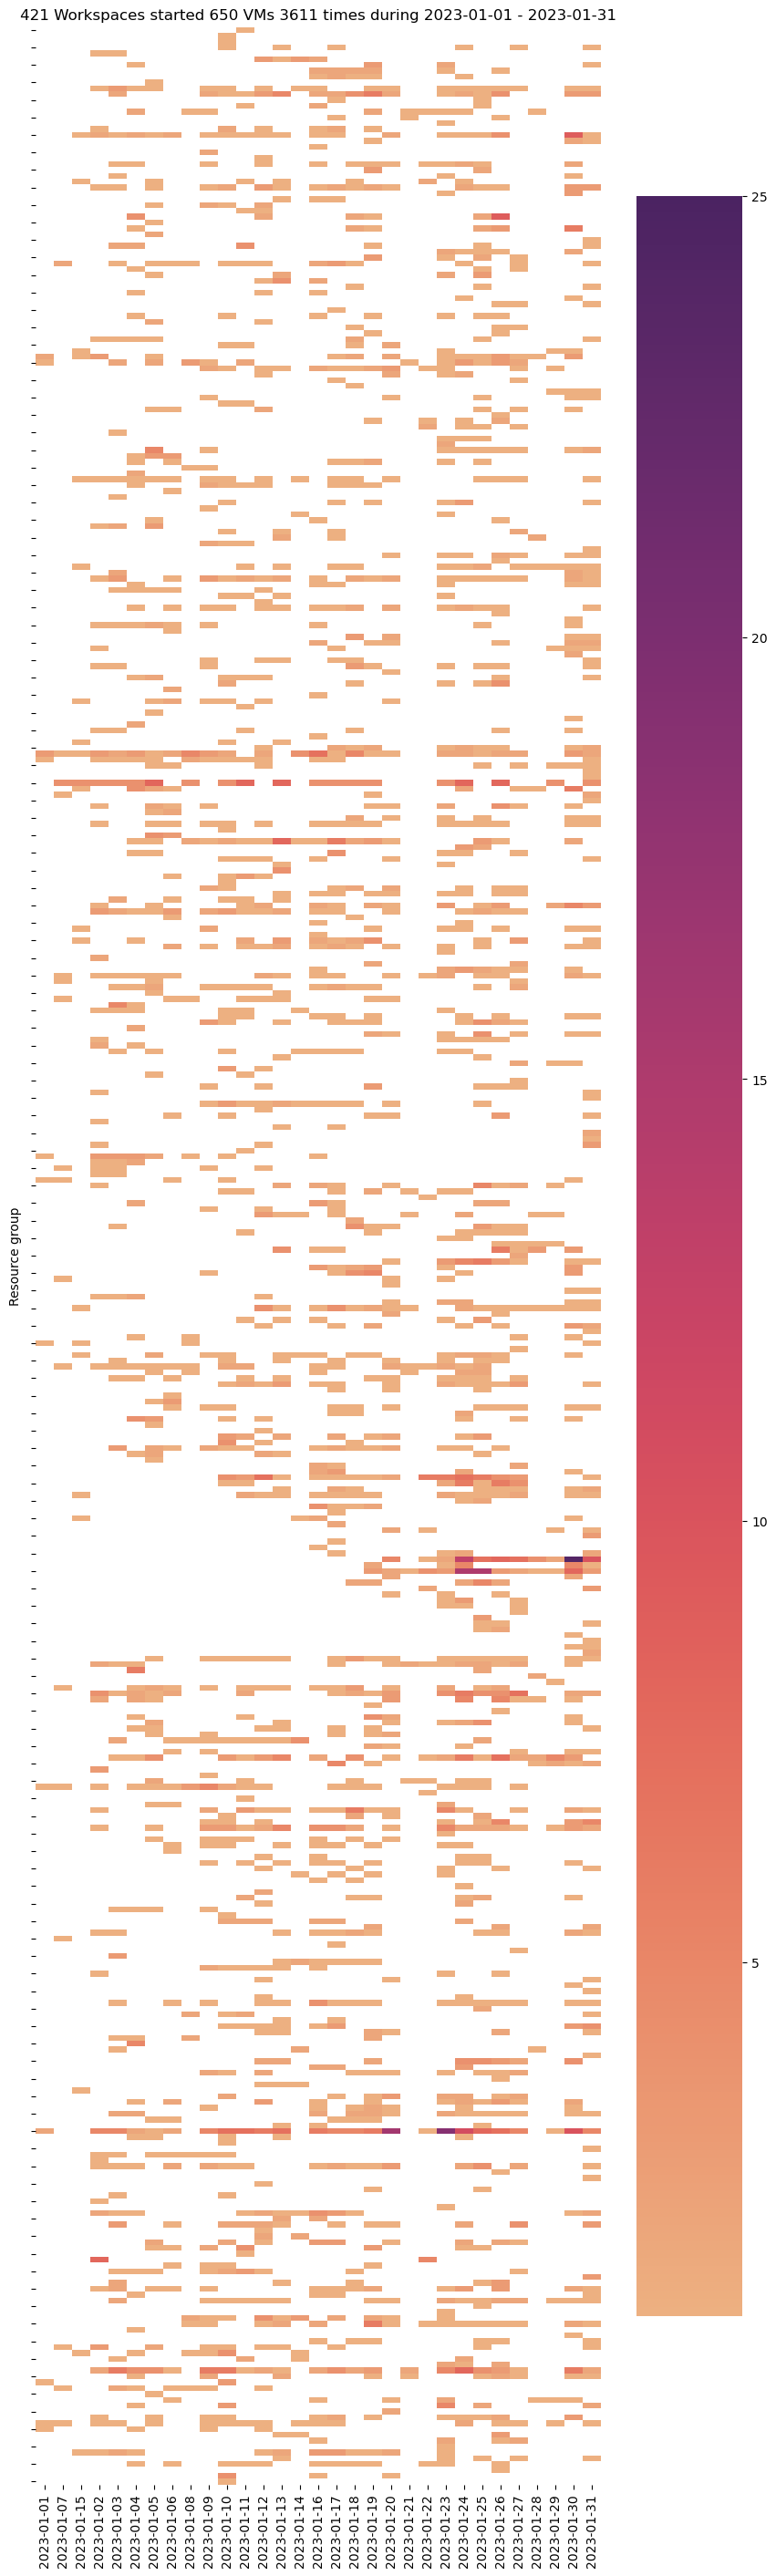

In [8]:
item = 'Resource group'
table=reduced_data.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
wss = len(result)
title=f'{wss} Workspaces started {vms} VMs {vm_starts} times during {min(result.columns)} - {max(result.columns)}'
figure, ax = plt.subplots(figsize=(10,35))
figure = sns.heatmap(result, cmap='flare', mask=result<1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
ax.set_yticklabels([])
figure.invert_xaxis()
figure.figure.savefig('myDRE/workspace_activity_' +date+'.png',  bbox_inches='tight')

## Active WSs in Subscription

- Number of Active WSs per day per subsription
   - Active WS = 1 or more VM start succeeeded of that WS

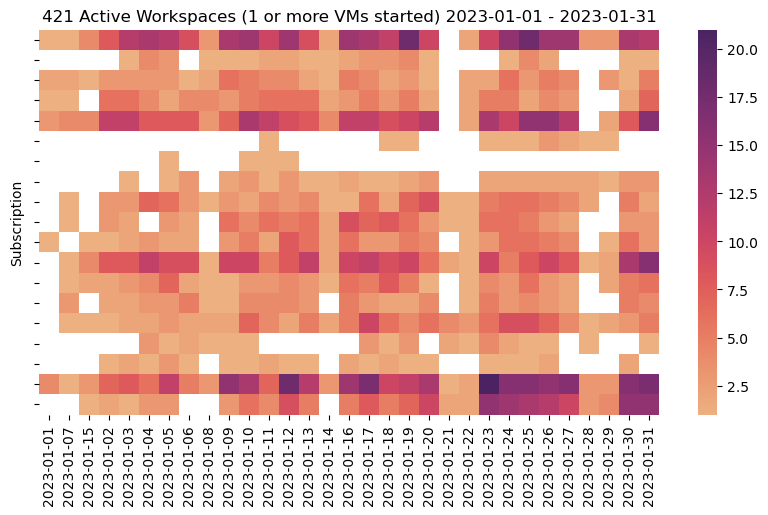

In [9]:
reduced_data2 = reduced_data[['Time', 'Subscription', 'Resource group']].unique()
reduced_data2=reduced_data2.with_columns(pl.lit(1).alias('Counter'))
item = 'Subscription'
table=reduced_data2.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
active_wss = len(set(reduced_data2['Resource group']))
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
title=f'{active_wss} Active Workspaces (1 or more VMs started) {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
figure = sns.heatmap(result, cmap='flare', mask=result<1) #, vmin=1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
ax.set_yticklabels([])
figure.invert_xaxis()
figure.figure.savefig('myDRE/sub_workspace_activity_' +date+'.png',  bbox_inches='tight')

## # of Active Users

- Number of Users per day per subsription
   - Active user = started 1 or more VM start succeeeded

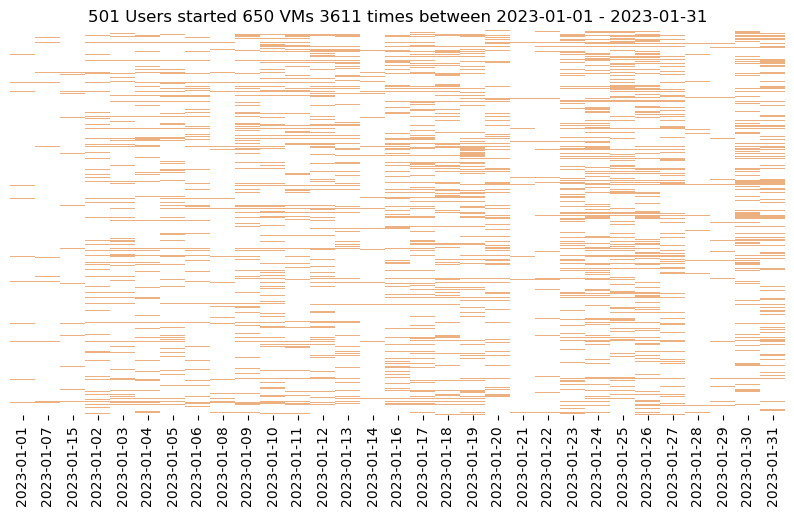

In [10]:
reduced_data3 = reduced_data[['Time', 'Event initiated by']].unique()
reduced_data3=reduced_data3.with_columns(pl.lit(1).alias('Counter'))
item = 'Event initiated by'
table=reduced_data3.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
active_users = len(set(reduced_data3['Event initiated by']))
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
title=f'{active_users} Users started {vms} VMs {vm_starts} times between {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(result, cmap='flare', mask=result<1, cbar=False) #, vmin=1, vmax=(max(result.max())//5+1)*5)
ax.set(title=title)
ax.set(ylabel=None)
ax.tick_params(left=False)
ax.set_yticklabels([])
ax.invert_xaxis()
figure.figure.savefig('myDRE/user_activity_' +date+'.png',  bbox_inches='tight')

# Identify the real users for a client

In [11]:
def replace(x):
    try:
        x = user_alternate_dic[x].lower()
    except:
        pass
    return x

In [44]:
reduced_data3=reduced_data.with_columns((pl.col('Event initiated by').apply(lambda x: replace(x))).alias('alternateEmailAddress'))
reduced_data3=reduced_data3.with_columns((pl.col('alternateEmailAddress').apply(lambda x: x.split('@')[1])).alias('Organization'))
unique_email = pl.Series(reduced_data3["Organization"].unique()).to_frame('Organization')
n=80
print(f'{"*"*n}')
txt = f'Number of unique @something: {len(unique_email)}'
print(f'{txt:^80}')
print(f'{"*"*n}')
unique_email.write_csv('myDRE/unique_collaboration-'+date+'.csv')

********************************************************************************
                        Number of unique @something: 83                         
********************************************************************************


In [13]:
def own_people(TENANT):
    reduced_data4 = reduced_data3.filter(pl.col('alternateEmailAddress').str.contains(client_dictionary['email'][TENANT]))
    reduced_data4.write_csv('data_'+TENANT + '\own_people-' + TENANT + '_'+date+'.csv')
    reduced_data4=reduced_data4.filter(~pl.col('Tenant').str.contains(TENANT))
    # reduced_data4=reduced_data4[['Subscription', 'Resource group', 'alternateEmailAddress']].unique()
    reduced_data4=reduced_data4.groupby(['Tenant', 'Subscription', 'Resource group', 'alternateEmailAddress']).agg([pl.col('Counter').max()])
    reduced_data4.write_csv('data_'+TENANT + '\own_people_other_tenant-' + TENANT + '_'+date+'.csv')
    table=reduced_data4.pivot(columns=['Tenant'], index='alternateEmailAddress', values=['Counter'], aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(f'Collaboarations with other Tenants\n')
    return table

In [14]:
def own_ws(TENANT):
    reduced_data5 = reduced_data3.filter(pl.col('Subscription').str.contains(TENANT))
    reduced_data5.write_csv('data_'+TENANT + '\own_ws-' + TENANT + '_'+date+'.csv')
    reduced_data5=reduced_data5.filter(~pl.col('Organization').str.contains(client_dictionary['email'][TENANT][1:]))
    reduced_data5=reduced_data5.groupby(['Tenant', 'Organization', 'Resource group', 'alternateEmailAddress']).agg([pl.col('Counter').max()])
    reduced_data5.write_csv('data_'+TENANT + '\own_ws_other_people-' + TENANT + '_'+date+'.csv')
    table=reduced_data5.pivot(columns=['Organization'], index='Resource group', values=['Counter'], aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(f'Collaboarations with other Parties\n')
    return table

In [15]:
def vm_activity(TENANT):
    item = 'Subscription'
    temp=reduced_data
    temp=temp.filter(pl.col('Subscription').str.contains(TENANT))
    table=temp.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(table)
    result = table.to_pandas()
    result = result.set_index(item)
    result.sort_index(level=0, ascending=True, inplace=True)
    vms = len(temp['VM'])
    vm_starts = sum(temp['Counter'])
    title=f'{vms} VMs with {vm_starts} Succeeded starts during {min(result.columns)} - {max(result.columns)}'
    figure, ax = plt.subplots(figsize=(10,5))
    figure = sns.heatmap(result, cmap='flare', mask=result<1, vmin=1, vmax=(max(result.max())//5+1)*5)
    figure.set(title=title)
    figure.invert_xaxis()
    figure.figure.savefig('data_'+TENANT+ '/sub_vm_activity_' +date+'.png',  bbox_inches='tight')
    plt.close()

In [16]:
def workspace_activity(TENANT):
    temp=reduced_data
    temp=temp.filter(pl.col('Subscription').str.contains(TENANT))
    temp=temp[['Time', 'Subscription', 'Resource group']].unique()
    temp=temp.with_columns(pl.lit(1).alias('Counter'))
    item = 'Subscription'
    table=temp.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(table)
    active_wss = len(set(temp['Resource group']))
    result = table.to_pandas()
    result = result.set_index(item)
    result.sort_index(level=0, ascending=True, inplace=True)
    title=f'{active_wss} Active Workspaces (1 or more VMs started) {min(result.columns)} - {max(result.columns)}'
    figure, ax = plt.subplots(figsize=(10,5))
    figure = sns.heatmap(result, cmap='flare', mask=result<1) #, vmin=1, vmax=(max(result.max())//5+1)*5)
    figure.set(title=title)
    figure.invert_xaxis()
    figure.figure.savefig('data_'+TENANT+ '/sub_workspace_activity_' +date+'.png',  bbox_inches='tight')
    plt.close()

In [17]:
def per_workspace_activity(TENANT):
    item = 'Resource group'
    temp=reduced_data
    temp=temp.filter(pl.col('Subscription').str.contains(TENANT))
    table=temp.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(table)
    result = table.to_pandas()
    result = result.set_index(item)
    result.sort_index(level=0, ascending=True, inplace=True)
    wss = len(result)
    vms = len(set(temp['VM']))
    vm_starts = sum(temp['Counter'])
    wss = len(result)
    title=f'{wss} Workspaces started {vms} VMs {vm_starts} times during {min(result.columns)} - {max(result.columns)}'
    figure, ax = plt.subplots(figsize=(10,35))
    figure = sns.heatmap(result, cmap='flare', mask=result<1, vmax=(max(result.max())//5+1)*5)
    figure.set(title=title)
    figure.invert_xaxis()
    figure.figure.savefig('data_'+TENANT+ '/per_workspace_activity_' +date+'.png',  bbox_inches='tight')
    plt.close()

In [18]:
def user_activity(TENANT):
    temp=reduced_data
    temp=temp.filter(pl.col('Subscription').str.contains(TENANT))
    vms = len(set(temp['VM']))
    temp=temp[['Time', 'Event initiated by']].unique()
    temp=temp.with_columns(pl.lit(1).alias('Counter'))
    item = 'Event initiated by'
    table=temp.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
    # print(table)
    active_users = len(set(temp['Event initiated by']))
    result = table.to_pandas()
    result = result.set_index(item)
    result.sort_index(level=0, ascending=True, inplace=True)
    vm_starts = sum(temp['Counter'])
    active_users = len(set(temp['Event initiated by']))
    title=f'{active_users} Users started {vms} VMs {vm_starts} times between {min(result.columns)} - {max(result.columns)}'
    figure, ax = plt.subplots(figsize=(10,5))
    ax = sns.heatmap(result, cmap='flare', mask=result<1, cbar=False) #, vmin=1, vmax=(max(result.max())//5+1)*5)
    ax.set(title=title)
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set_yticklabels([])
    ax.invert_xaxis()
    figure.figure.savefig('data_'+TENANT+ '/user_activity_' +date+'.png',  bbox_inches='tight')
    plt.close()

In [19]:
funcs = [own_ws, vm_activity, workspace_activity, per_workspace_activity, user_activity]

for TENANT in client_dictionary['email']:
    if not os.path.exists('data_'+TENANT):
        os.mkdir('data_'+TENANT)
    for func in funcs:
        try:
            func(TENANT)
        except:
            print(func, TENANT)


<function vm_activity at 0x000002A174DC3640> DRWN
<function workspace_activity at 0x000002A174DC37F0> DRWN
<function per_workspace_activity at 0x000002A17B550EE0> DRWN
<function user_activity at 0x000002A17B552F80> DRWN
